In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Load dataset
df=pd.read_csv('data/oct_march_prepared_data.csv')

In [3]:
# Map categorical priority to numeric
priority_map = {'Low': 0, 'Medium': 1, 'High': 2}
df['Last Priority'] = df['Last Priority'].map(priority_map)

### Feature Engineering

In [4]:
# Device Usage Growth Ratio
df['device_growth_ratio'] = df['avg_device_count_last_2_months'] / (df['overall_avg_device_count'] + 1e-5)

# avg_usage_per_device
df['avg_usage_per_device'] = df['Average Data Usage'] / (df['overall_avg_device_count'] + 1e-5)

In [5]:
df.head(5)

,Customer ID,Tk Count Within 30 Days,Tk Count Within 60 Days,Previous Termination Attempts,Last Priority,Average Life Time,Max Life Time,Loyalty Duration,On Going Ticket,Status,Total Data Usage,Average Data Usage,overall_avg_device_count,avg_device_count_last_2_months,device_growth_ratio,avg_usage_per_device
0,2074729,0,1,0,0,1.04,1.94,2251.97,0,ACTIVE,1434.55,239.09,9.67,11.5,1.189244,24.724897
1,2514023,0,1,0,0,1.61,2.70,372.54,0,ACTIVE,722.59,120.43,5.00,5.5,1.099998,24.085952
2,2288502,0,2,0,0,2.32,3.02,1297.96,0,ACTIVE,472.14,78.69,4.67,6.0,1.284794,16.850071
3,2114773,0,0,0,1,2.77,3.32,1872.54,0,ACTIVE,453.30,75.55,8.33,8.0,0.960383,9.069617
4,2380314,0,0,0,0,1.59,2.22,950.07,0,ACTIVE,847.79,141.30,7.33,8.0,1.091404,19.276918


Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.6986607142857143
              precision    recall  f1-score   support

      ACTIVE       0.66      0.84      0.74       226
  TERMINATED       0.77      0.55      0.65       222

    accuracy                           0.70       448
   macro avg       0.72      0.70      0.69       448
weighted avg       0.71      0.70      0.69       448



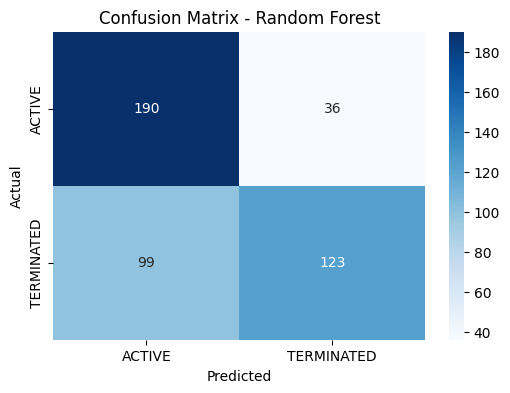

In [6]:
X = df.drop(['Status','Customer ID'], axis=1)
y = df['Status']

# Label encode the target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Undersample the majority class
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define and tune Random Forest model
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4, 5, 6],
    'criterion': ['gini', 'entropy']
}
grid = GridSearchCV(rf, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

# Predict
y_pred = best_model.predict(X_test)

# Evaluation
print("Best Parameters:", grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [7]:
joblib.dump(best_model,'/home/thiri/Documents/RT Projects/Version1/rt_model/random_forest_model.pkl')

['/home/thiri/Documents/RT Projects/Version1/rt_model/random_forest_model.pkl']

## Correlation Heatmap

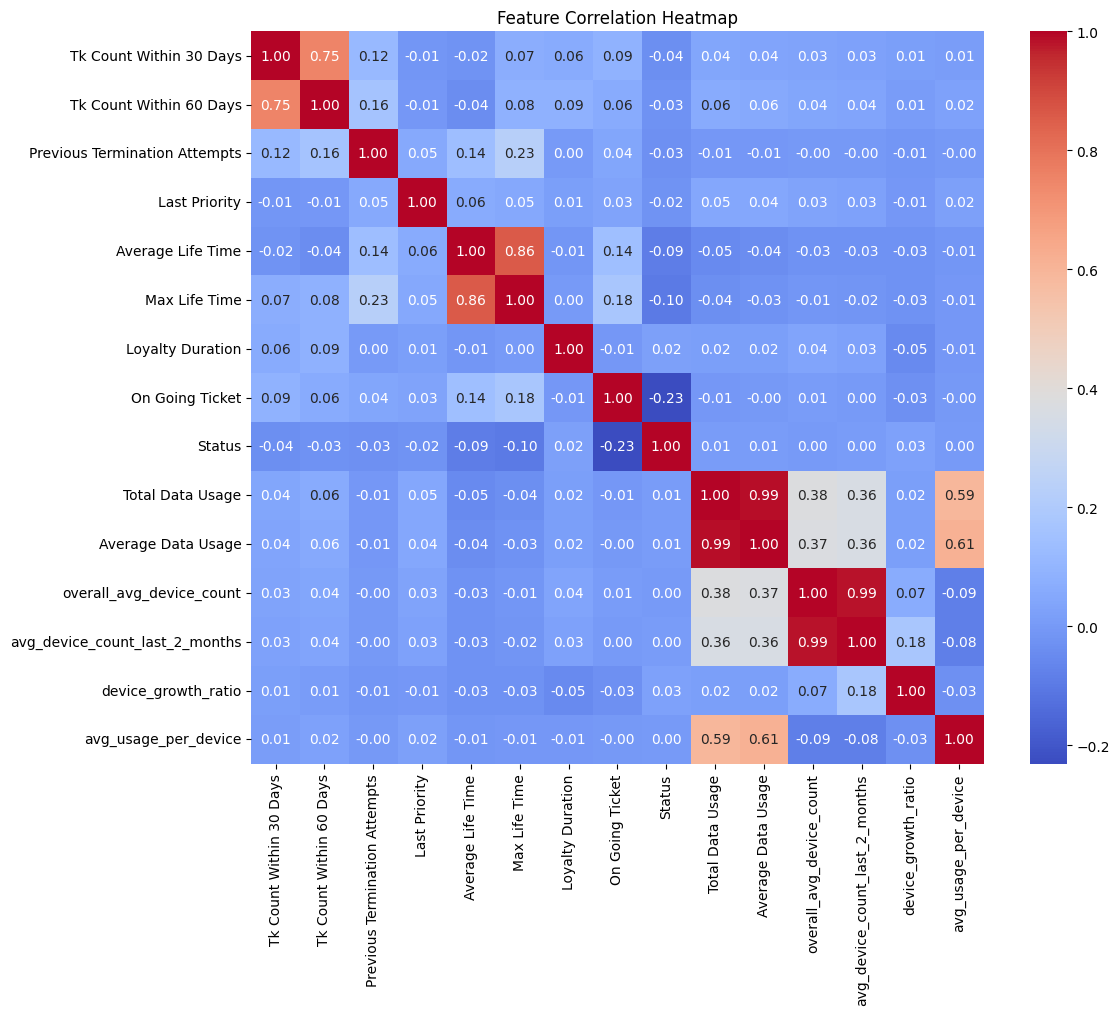

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Copy and encode
df_encoded = df.copy()
df_encoded['Status'] = df_encoded['Status'].map({'ACTIVE': 1, 'TERMINATED': 0})

# Select numeric columns and drop 'Customer ID'
numeric_df = df_encoded.select_dtypes(include=['number']).drop(columns=['Customer ID'])

# Compute and plot correlation matrix
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


## Feature Importance

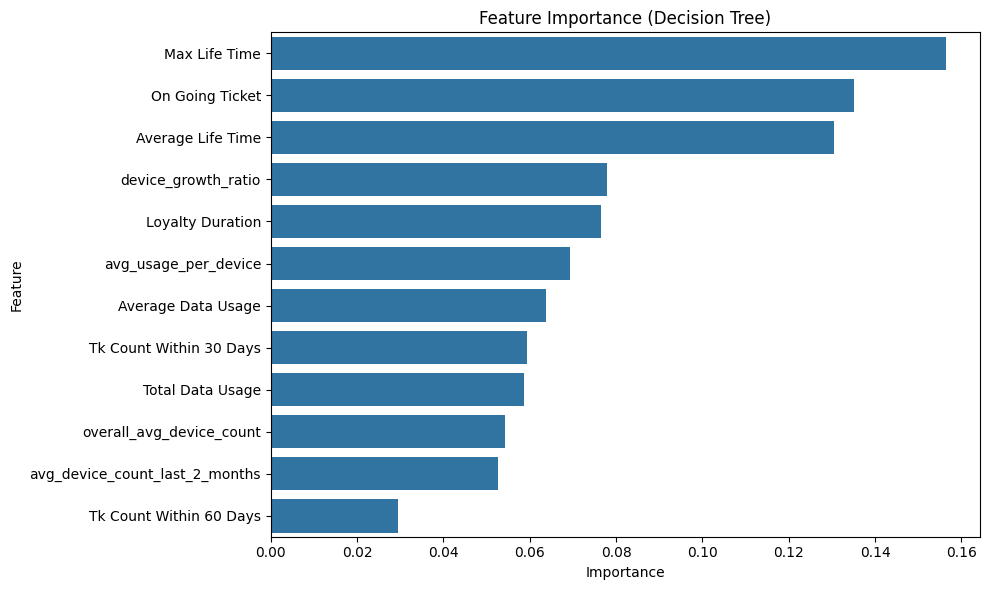

In [9]:
from xgboost import plot_importance
import joblib
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"feature_{i}" for i in range(X_train.shape[1])]
importances = best_model.feature_importances_

feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(12)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importance (Decision Tree)')
plt.tight_layout()
plt.show()
